In [41]:
import pickle
from torchvision import transforms
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

In [10]:
# set model
device = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device).eval()

In [11]:
# remove fc layer

embedd_model = torch.nn.Sequential(*list(model.children())[:-1])

In [6]:
# set imagenet transforms

image_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [44]:
def show_similar_images(imgs_path_lst, cos_distance, n=5):
    
    idxs = cos_distance.argsort()[:n]
    
    for idx in idxs:
        img_path = imgs_path_lst[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        plt.imshow(image)
        plt.title(f"Cosine Distance: {cos_distance[idx]:.4f}")
        plt.axis('off')
        plt.show();

In [13]:
def get_embeddings_from_img(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image).to(device)

        with torch.inference_mode():
            image_feat = embedd_model(image.unsqueeze(0)).squeeze(0).view(-1)
            image_feat = image_feat.cpu().numpy()
        
        return image_feat
    
    except Exception as e:
        print(f"[ERROR] Error processing image {image_path}: {e}")

In [37]:
def compute_images_similarity(img_feature, features_data_path):
    # read features data

    with open(features_data_path, "rb") as f:
        imgs_features = pickle.load(f)
    
    imgs_paths_lst = []
    imgs_features_lst = [] 

    for feat in imgs_features:
        imgs_paths_lst.append(feat["path"])
        imgs_features_lst.append(feat["features"])
        
    features_array = torch.tensor(np.vstack(imgs_features_lst))
    
    img_feature = torch.tensor(img_feature).unsqueeze(0)
    similarity = cosine_similarity(img_feature, features_array, dim=1)
    
    cos_distance = 1 - similarity
    
    return imgs_paths_lst, cos_distance

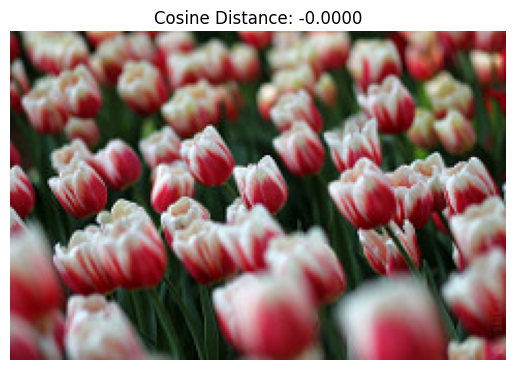

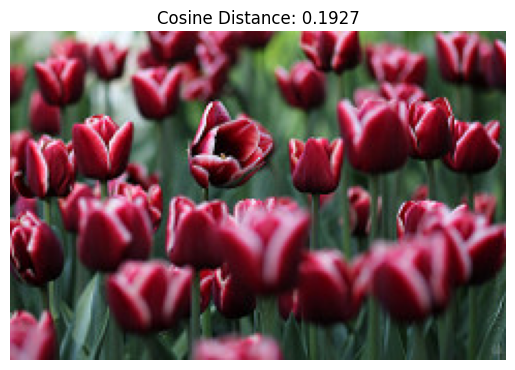

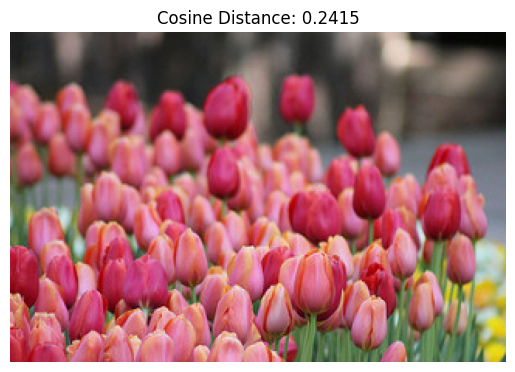

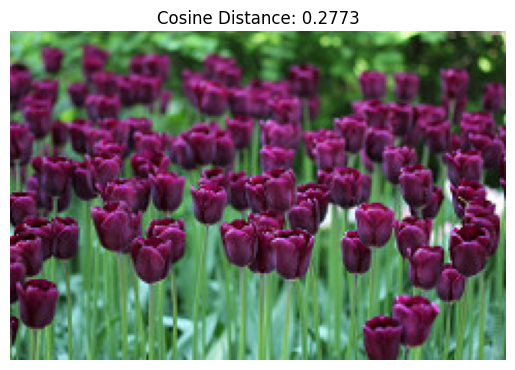

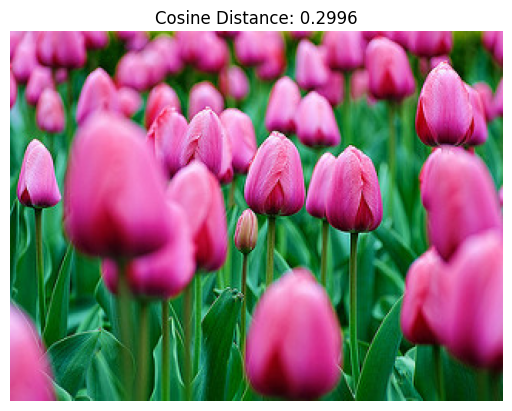

In [50]:
test_img_path = "../data/dataset/tulip/14254329062_140c0f4f4f_n.jpg"
features_data_path = "../data/features.pkl"

image_feature = get_embeddings_from_img(test_img_path)

imgs_path_lst, cos_distance = compute_images_similarity(
    img_feature=image_feature, 
    features_data_path=features_data_path,
)

show_similar_images(imgs_path_lst=imgs_path_lst, cos_distance=cos_distance)